# Уменьшение размерности и кластеризация методом `K-means` для выделения групп объектов

Применим методы кластеризации для решения непосредственно задачи кластеризации — задачи выделения схожих структур в данных. Работать будем с известным набором данных `MNIST`.

In [ ]:
from keras.datasets import mnist

Загрузим набор данных и оценим его размеры

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [ ]:
import matplotlib.pyplot as plt

Вот так выглядят тренировочные объекты и их метки классов

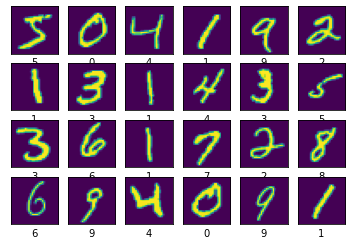

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i])
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y_train[i],
                   color='black')

Давайте сначала, раз речь идет об известном наборе данных, заставим `K-means` искать 10 групп объектов.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X_train.reshape(-1, 784))

Давайте посмотрим, как выглядят центры наших кластеров

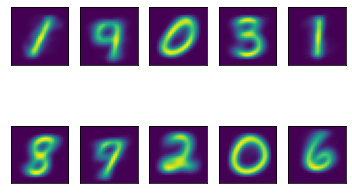

In [ ]:
fig, ax = plt.subplots(2, 5)
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center)

Получившиеся картинки весьма походят на рукописные цифры. Впрочем, не без ошибок. Единица представлена дважды (скорее всего, одна из них — семерка), девятка представлена дважды (наверное, одна из них — четверка), ноль представлен дважды (видимо, кто-то из них — пятерка).

Так как получившиеся кластеры ничего не знают о природе кластеризумых объектов, метки кластеров могут отличаться от «разумных меток». Давайте все переобозначим, присвоив кластеру метку тех цифр, которых в кластерое большинство.

In [ ]:
from scipy.stats import mode
import numpy as np

In [ ]:
true_labels = np.zeros_like(clusters)
cluster_values = []
for i in range(10):
    mask = (clusters == i)
    true_labels[mask] = mode(y_train[mask])[0]
    cluster_values.append(mode(y_train[mask])[0])

Можно видеть, что наши рассуждения выше были не совсем верными. Вот те метки классов, которые мы навесили на кластеры на основе частоты. Нет кластера, отвечающего цифрам $5$ и $9$, зато есть два кластера, отвечающих $0$ и $1$.

In [ ]:
cluster_values

[array([1], dtype=uint8),
 array([4], dtype=uint8),
 array([0], dtype=uint8),
 array([3], dtype=uint8),
 array([1], dtype=uint8),
 array([8], dtype=uint8),
 array([7], dtype=uint8),
 array([2], dtype=uint8),
 array([0], dtype=uint8),
 array([6], dtype=uint8)]

Разумно оценить что-то вроде точности. Правда, она «намекается» разговорами выше.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_train, true_labels)

0.5907166666666667

In [ ]:
from sklearn.metrics import confusion_matrix

А что с тестовым набором данных?

In [ ]:
clusters_test = kmeans.predict(X_test.reshape(-1, 784))
labels_test = np.zeros_like(clusters_test)
for i in range(10):
    mask = (clusters_test == i)
    labels_test[mask] = cluster_values[i][0]

Подтверждаются ли наши догадки фактами?

In [ ]:
mat = confusion_matrix(y_test, labels_test)
mat

array([[ 870,    5,    2,   48,    4,    0,   30,    3,   18,    0],
       [   0, 1129,    1,    2,    0,    0,    2,    0,    1,    0],
       [  22,  143,  709,   65,   30,    0,   25,   11,   27,    0],
       [  19,   80,   40,  696,   15,    0,    7,    7,  146,    0],
       [   2,   66,    5,    0,  559,    0,   35,  310,    5,    0],
       [  48,  128,    4,  287,   56,    0,   19,   70,  280,    0],
       [  44,   58,   18,    2,   22,    0,  794,    1,   19,    0],
       [   2,  116,   13,    0,  292,    0,    1,  603,    1,    0],
       [  17,   78,    6,  209,   34,    0,   10,   35,  585,    0],
       [  14,   40,    3,    7,  541,    0,    4,  387,   13,    0]])

In [ ]:
accuracy_score(y_test, labels_test)

0.5945

Интересно отметить, что мы построили классификатор на основе кластеризации при том, что никакими «правильными ответами» мы не пользовались (разве что для оценки).

А сколько кластеров кажется оптимальным количеством, если использовать каменистую осыпь?

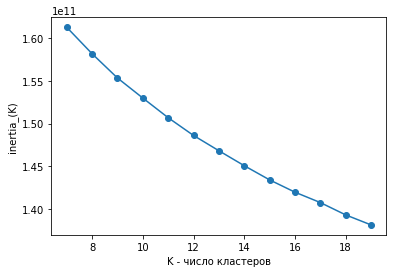

In [ ]:
n_c = range(7, 20)
inertia = [KMeans(n_clusters=k, random_state=0).fit(X_train.reshape(-1, 784)).inertia_ for k in n_c]

plt.plot(n_c, inertia, marker='o')
plt.xlabel('K - число кластеров')
plt.ylabel('inertia_(K)')
plt.show()

Пока не представляется возможным определить количество кластеров. Может быть, стоит увеличить диапазон возможностей, но..

Все эти обучения черезчур уж долгие. Давайте сделаем «ход конем» и понизим размерность данных, пытаясь сохранять расстояния между объектами. Посмотрим, как это скажется на скорости и точности.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, init='random', random_state=0)
projections = tsne.fit_transform(X_train.reshape(-1, 784))

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(projections)

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

accuracy_score(y_train, labels)

/Users/bojcevanton/miniconda3/envs/ipynb_installation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.9022166666666667

Проблема, однако, известна. `t-SNE` — метод, который не дает правила получения проекций многомерного пространства на, например, двумерное. Тем самым, при появлении новых данных, проекции придется искать заново.

В то же время, еще раз хочется подчеркнуть, как обучение без учителя позволило построить классификатор, который, как будто бы, является результатом решения задачи обучения с учителем.

# Использование `K-means` для сжатия


Еще одно полезное применение кластеризации — сжатие изображений. Схема до удивления проста: похожие, рядом расположенные цвета, стоит объединить в один цвет. Давайте провернем это самостоятельно на типовом изображении.

In [ ]:
from sklearn.datasets import load_sample_image

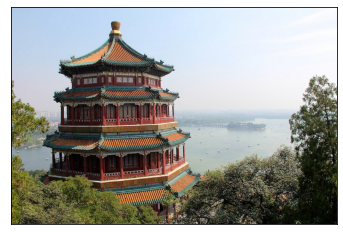

In [ ]:
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

Перед нами трехканальное (RGB) изображение размера $427 \times 640$ пикселей.

In [ ]:
china.shape

(427, 640, 3)

In [ ]:
data = china / 255
data = data.reshape(427*640, 3)

Давайте убедимся в том, что исходное пространство цветов, насчитывающее около $16$ миллионов возможных состояний ($256^3$), слишком велико, и его можно понижать. Для наглядности построим лишь некоторые подвыборки зависимостей значений интенсивностей и лишь на случайном поднаборе пикселей.

In [ ]:
def plot_pixels(data, colors=None, N=10000):
    if colors is None:
        colors = data

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

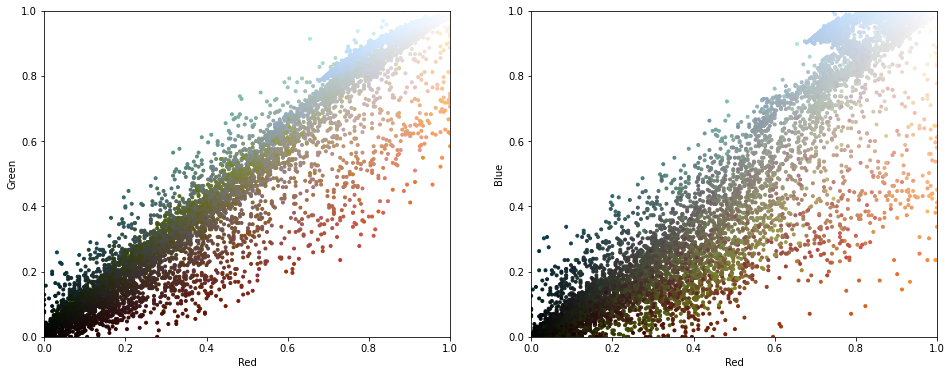

In [ ]:
plot_pixels(data)

Переведем 16 миллионов возможностей во всего-навсего 16 возможностей, используя `K-means`. Правда, чтобы ускорить работу алгоритмы, мы бутем использовать `K-means` на батчах — поднаборах данных. Заодно увидим, портит ли это результат

In [ ]:
from sklearn.cluster import MiniBatchKMeans

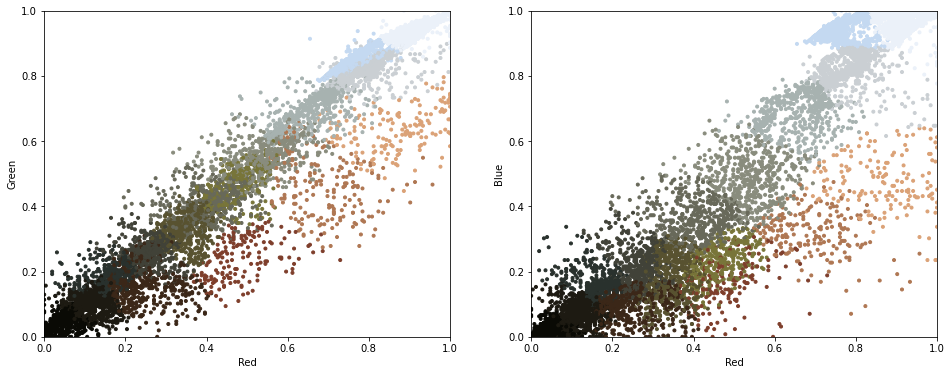

In [ ]:
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors)


Пора смотреть на результат!

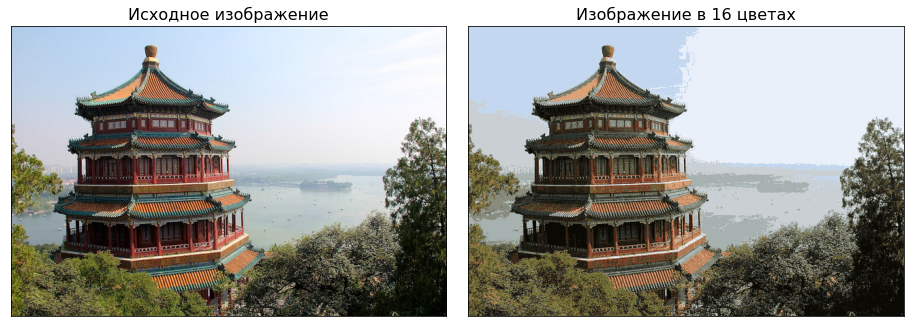

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Исходное изображение', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('Изображение в 16 цветах', size=16);

# Генеративная модель на основе гауссовых смесей

Гауссовы смеси — естественное математическое обобщение алгоритма `K-means`. По сути, подход ищет не просто какие-то кучки вокруг формирующихся центроидов, а некоторую смесь многомерных нормальных распределений (по сути — тоже кучки вокруг средних со своими дисперсиями). Так как такой подход оценивает плотности распределений, то он часто используется в задачах KDE (kernel density estimation). В том числе, он может быть применен к задаче генерации: если есть плотность распределения, то можно семплировать и получать новые объекты. Давайте посмотрим на простейший пример решения такой задачи

Работать будем опять-таки с `MNIST`. Так как модель оказывается крайне тяжеловесной, будем использовать «простой» набор данных. Визуализируем элементы этого набора данных (для наглядности)

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

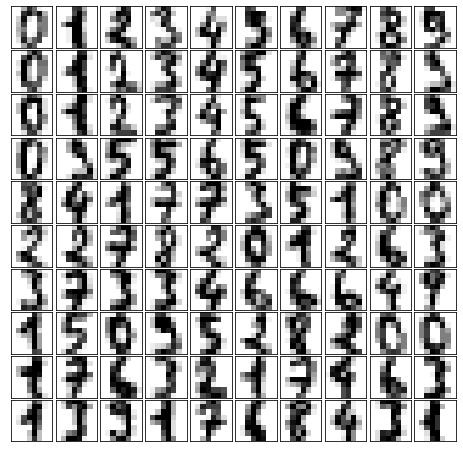

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits.data[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

Чтобы обучение проходило быстрее, понизим размерность нашего пространства признаков


In [2]:
from sklearn.decomposition import PCA

In [3]:
pca = PCA(0.99)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Количество признаков удалось уменьшить где-то в треть. Обучим интересующую нас модель.


In [4]:
from sklearn import mixture

Минимизируем информационный критерий Акаике для поиска наиболее удачной модели

In [6]:
random_state = 13
import numpy as np

n_components = np.arange(50, 250, 10)
gmm_models = [mixture.GaussianMixture(n_components=n, covariance_type='full', random_state=random_state) for n in n_components]
aics = [model.fit(data).aic(data) for model in gmm_models]

In [7]:
aics

[172644.534980928,
 100168.89083586293,
 47518.555895626865,
 -25087.67015141851,
 -67826.27493919682,
 -101552.18677138764,
 -124095.91952806362,
 -149469.2869874013,
 -167429.89342504903,
 -179454.78837708803,
 -167613.35947222292,
 -174393.3179044138,
 -171674.91291626485,
 -184546.03626216168,
 -181971.08236695617,
 -175729.2153281601,
 -166851.52537617506,
 -159419.46382239403,
 -156497.87550051813,
 -151145.7698325381]

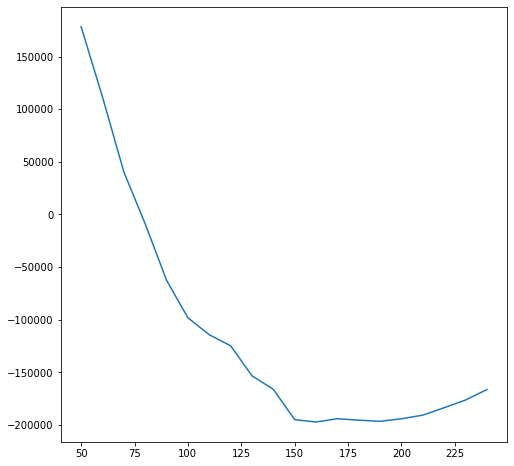

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(n_components, aics)

Обучим финальную модель на подобранном нами гиперпараметре. Проверим, что обучение сошлось.

In [ ]:
final_model = mixture.GaussianMixture(150, covariance_type='full', random_state=0)
final_model.fit(data)
print(final_model.converged_)

True


Сгенерируем новые данные

In [ ]:
data_new, _ = final_model.sample(100)
data_new

array([[ -2.89845573,  21.06495228,  -4.28075344, ...,  -0.34058812,
          0.90021736,  -1.32727472],
       [ -2.78651183,  26.47587115,  -4.26242779, ...,  -1.52884296,
          0.21481938,   0.16561775],
       [ 11.87203035,  17.02471723,  14.93798027, ...,  -0.12773838,
         -2.26244087,   0.30278747],
       ...,
       [  7.01054732, -15.129755  , -24.75734107, ...,   2.2409855 ,
         -3.9644268 ,  -0.95139339],
       [ 16.77041251,  15.21052707,  12.99340671, ...,  -0.30719693,
          1.5647553 ,   1.77213535],
       [ 17.5028367 ,  13.71537905,  14.47021091, ...,  -0.92638337,
          1.8742804 ,   2.62356691]])

Вернем их в исходное пространство признаков

In [ ]:
digits_new = pca.inverse_transform(data_new)

Визуализируем результат

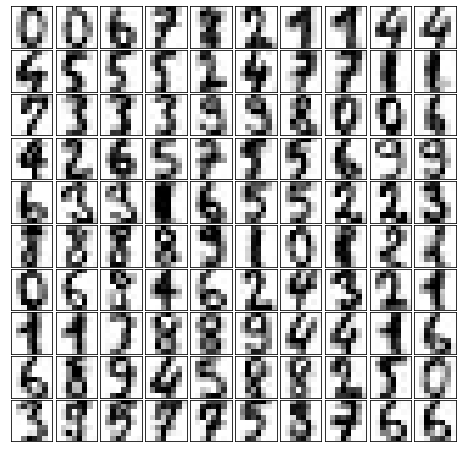

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits_new[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)
